<a href="https://colab.research.google.com/github/nashira-sy/CNN-WOA-Skin-cancer-detection/blob/main/CNN_WOA_Skin_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Py-FS
!pip install ReliefF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ReliefF: filename=ReliefF-0.1.2-py3-none-any.whl size=6303 sha256=9b47ec4d982c2b6b815e59e8d6d20568fca37fa93bbf180a7221c6312615cfdb
  Stored in directory: /root/.cache/pip/wheels/35/bc/0b/14a0227d4829b6b27f25de250213eb348b094d075be7604707
Successfully built ReliefF


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
import warnings
warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

import seaborn as sns
from sklearn import svm, preprocessing, model_selection, metrics, base
from keras.models import Sequential
from tensorflow.keras import layers

from Py_FS.wrapper.nature_inspired import GA, GWO, WOA, PSO

**Load Data**

In [ ]:
#https://drive.google.com/file/d/19vJXsnO1iC2cAmEpG9_cBgbBOAqqxf5V/view?usp=sharing
!gdown 19vJXsnO1iC2cAmEpG9_cBgbBOAqqxf5V

Downloading...
From (original): https://drive.google.com/uc?id=19vJXsnO1iC2cAmEpG9_cBgbBOAqqxf5V
From (redirected): https://drive.google.com/uc?id=19vJXsnO1iC2cAmEpG9_cBgbBOAqqxf5V&confirm=t&uuid=b1f82e9a-ce2b-4f71-bba7-8bb067d47746
To: /content/cancer_dataset.zip
100% 103M/103M [00:00<00:00, 138MB/s] 


In [ ]:
#unzip dataset
%%capture
!unzip cancer_dataset.zip;

In [ ]:
path = r"/content/cancer_dataset"

dataset = tf.keras.utils.image_dataset_from_directory(directory = path, batch_size = 10, image_size = (244, 244))

Found 10605 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names

class_map = {i : class_name for i, class_name in enumerate(class_names)}
reverse_class_map = {val : key for val, key in class_map.items()}

print(class_map)

{0: 'benign', 1: 'malignant'}


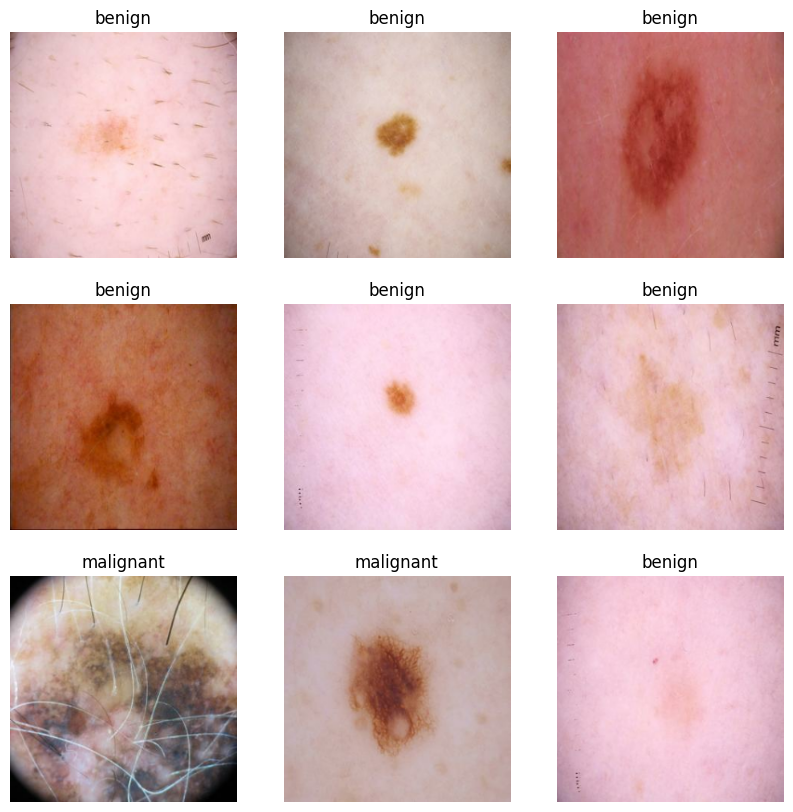

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Function for extracting the features from the dataset through feature extraction model
def get_features_labels(dataset, model):
    X, y = [], []
    for images, labels in dataset:
        features = model.predict([images,images])
        X.extend(features)
        y.extend(labels)

    X = np.array(X)
    y = np.array(y)
    return X, y


**Model CNN**

In [ ]:
base_model = Sequential([
    Conv2D(16, (3,3), 1, activation="relu", input_shape=(244,244,3), padding="same"),
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    Conv2D(32, (3,3), 1, activation="relu", padding="same"),
    Conv2D(32, (5,5), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    Conv2D(64, (3,3), 1, activation="relu", padding="same"),
    Conv2D(64, (3,3), 1, activation="relu", padding="same"),
    MaxPooling2D(),

    Flatten(),
])
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
base_model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics = ["accuracy"])

In [ ]:
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 244, 244, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 244, 244, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 122, 122, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 122, 122, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 122, 122, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,464 (345.56 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 88,464 (345.56 KB)

In [ ]:
X, y = get_features_labels(dataset, model = base_model)

print(X.shape, y.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

In [ ]:
# Splitting the dataset into train and test datasets
%%capture
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 3, stratify = y)

print(X_train.shape, X_test.shape)

In [ ]:
# Checking whether the labels are uniformely distributed across the train and test sets

def test_uniformity(y_train, y_test, class_names):
    plt.figure(figsize = (15, 5))

    plt.subplot(1, 2, 1)
    plt.title("Training Set")
    plt.xticks(ticks = np.arange(len(class_names)))
    sns.histplot(y_train, bins = len(class_names))

    plt.subplot(1, 2, 2)
    plt.title("Testing Set")
    plt.xticks(ticks = np.arange(len(class_names)))
    sns.histplot(y_test, bins = len(class_names))

    plt.tight_layout()
    plt.show()

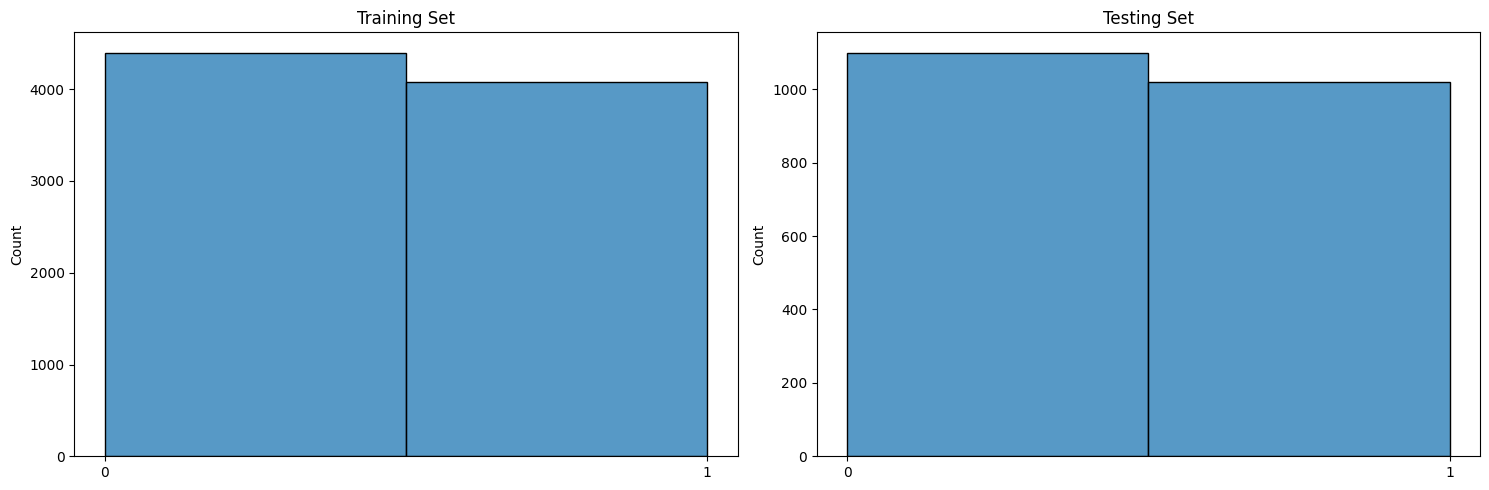

In [ ]:
test_uniformity(y_train, y_test, class_names)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
base_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units = 246, activation = "relu", kernel_initializer = "he_normal"),
    tf.keras.layers.Dense(units = 128, activation = "relu", kernel_initializer = "he_normal"),
    #tf.keras.layers.Dense(units = 32, activation = "relu", kernel_initializer = "he_normal"),
    tf.keras.layers.Dense(units = 2, activation = "softmax")
])

base_model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics = ["accuracy"])

history = base_model.fit(X_train, y_train, epochs = 100, validation_split = 0.2)

Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6442 - loss: 31.3301 - val_accuracy: 0.8315 - val_loss: 1.5353
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7391 - loss: 4.0205 - val_accuracy: 0.7684 - val_loss: 1.8132
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7958 - loss: 1.1570 - val_accuracy: 0.8332 - val_loss: 0.8149
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8081 - loss: 0.8441 - val_accuracy: 0.4779 - val_loss: 5.9397
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7640 - loss: 1.2081 - val_accuracy: 0.7443 - val_loss: 1.6979
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8037 - loss: 0.8262 - val_accuracy: 0.8379 - val_loss: 0.3953
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7382 - loss: 1.4770 - val_accuracy: 0.8651 - val_loss: 0.3309
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8473 - loss: 0.3556 - val_ac

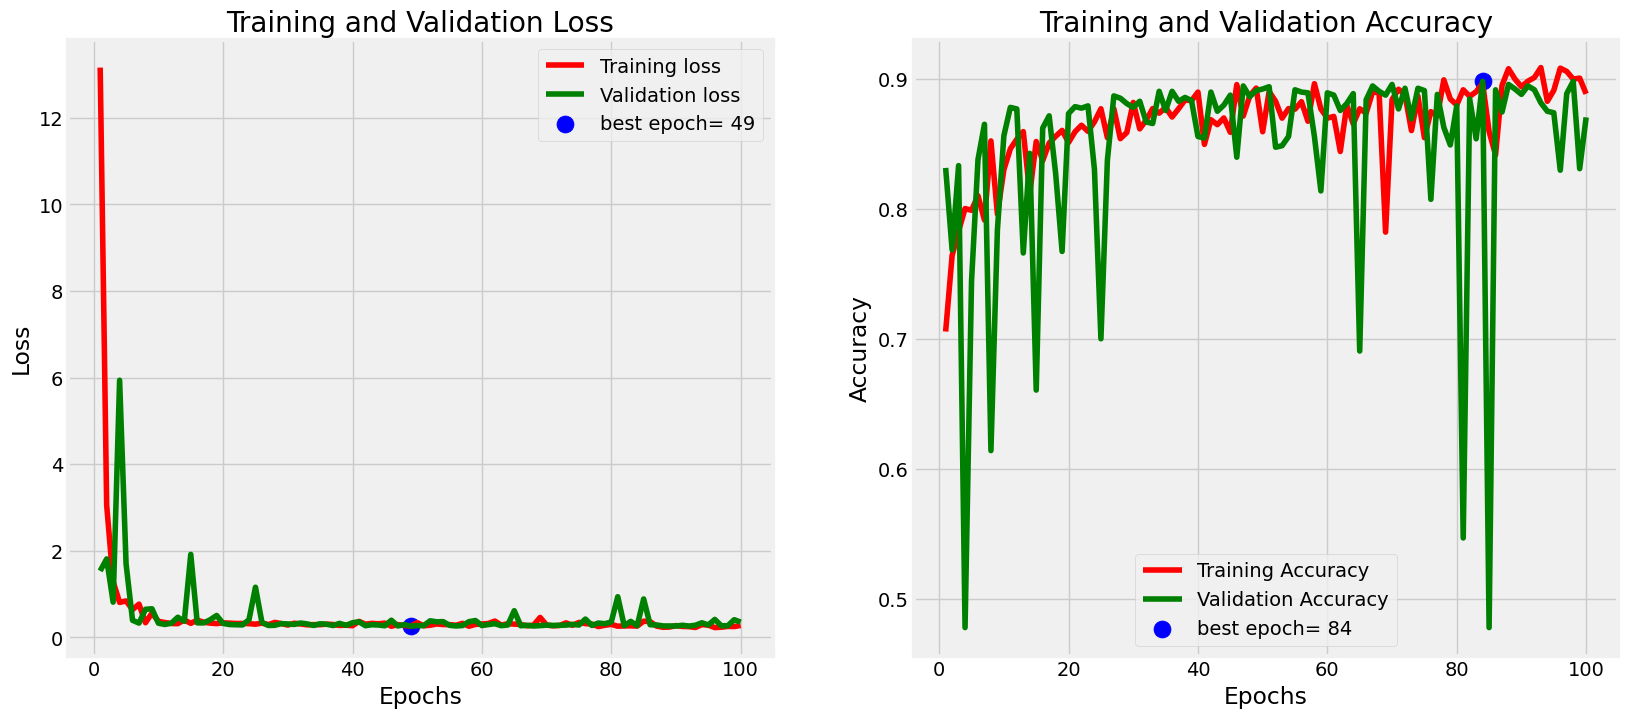

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = base_model.evaluate(X_train, y_train) # Use base_model
test_score = base_model.evaluate(X_test, y_test) # Use base_model

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", test_score[0])
print("Validation Accuracy: ", test_score[1])
print('-' * 20)

266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8920 - loss: 0.2858
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8677 - loss: 0.3386
Train Loss:  0.3030027449131012
Train Accuracy:  0.8867279291152954
--------------------
Validation Loss:  0.3235054612159729
Validation Accuracy:  0.8656294345855713
--------------------


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


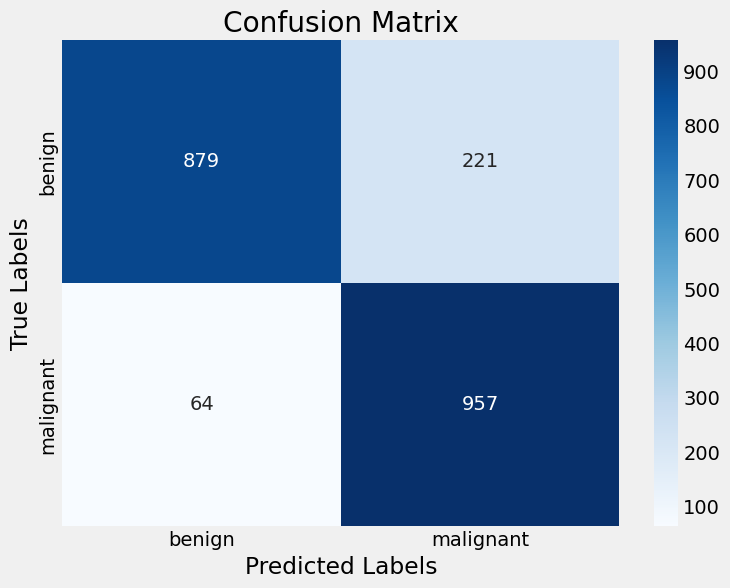

              precision    recall  f1-score   support

      benign       0.93      0.80      0.86      1100
   malignant       0.81      0.94      0.87      1021

    accuracy                           0.87      2121
   macro avg       0.87      0.87      0.87      2121
weighted avg       0.87      0.87      0.87      2121



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Predict classes for the test set
y_pred = base_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


**Whale Optimization Algorithm**

In [ ]:
# Converting the features into reduced features by applying feature masks ( feature selection )

def reduce_features(X, feature_mask):
    return pd.DataFrame(X).iloc[:, feature_mask].values

In [ ]:
# Selecting a random subset from whole population

def select_subset(subset_size, X, y):
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = model_selection.train_test_split(X, y, test_size = subset_size / X.shape[0], random_state = 3, stratify = y)
    return X_test_subset, y_test_subset

In [ ]:
# Fitness function utilizing best model

def fun(agent, X_train, X_val, y_train, y_val, weight_acc):
    model = tf.keras.models.clone_model(base_model)
    model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
    cb1 = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
    history = model.fit(X_train, y_train, epochs = 100, callbacks = [cb1], validation_data = (X_val, y_val), verbose = "silent")
    return model.evaluate(X_val, y_val)[1]

Enter the percentage of data wanted for valdiation [0, 100]: 20
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8812 - loss: 0.2628
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8725 - loss: 0.2643
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/

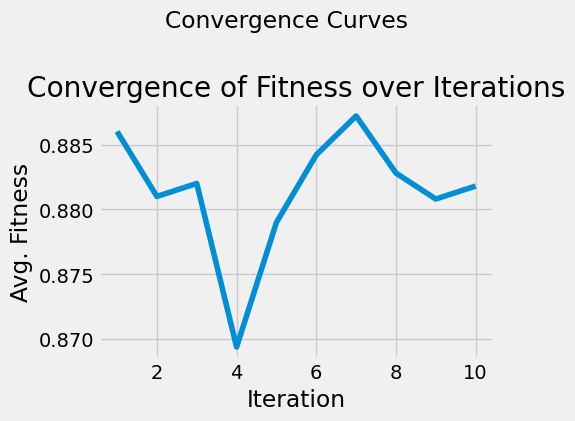

In [ ]:
# Whale Optimization Algorithm
X_train_subset, y_train_subset = select_subset(subset_size = 5000, X = X_train, y = y_train)
woa_fs = WOA(num_agents = 5, max_iter =  10, train_data = X_train_subset, train_label = y_train_subset, obj_function = fun)

In [ ]:
optimal_num_features = woa_fs.best_agent.sum()
print("Optimal feature subset size: ", optimal_num_features)
print(f"% reduction in feature size: {100 - optimal_num_features / woa_fs.num_features * 100} %")

Optimal feature subset size:  9557.0
% reduction in feature size: 33.63194444444444 %


In [ ]:
# Training the model on selected features i.e., optimal feature subset


feature_mask = woa_fs.best_agent.astype(bool)

X_train_ = reduce_features(X_train, feature_mask)
X_test_ = reduce_features(X_test, feature_mask)

print(X_train_.shape, X_test_.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units = 512, activation = "relu", kernel_initializer = "he_normal"),
    tf.keras.layers.Dense(units = 256, activation = "relu", kernel_initializer = "he_normal"),
    tf.keras.layers.Dense(units = 128, activation = "relu", kernel_initializer = "he_normal"),
    tf.keras.layers.Dense(units = 64, activation = "relu", kernel_initializer = "he_normal"),
    tf.keras.layers.Dense(units = 2, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
#cb1 = tf.keras.callbacks.EarlyStopping(patience = 20, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2)

(8484, 9557) (2121, 9557)
Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.6187 - loss: 10.1972 - val_accuracy: 0.8279 - val_loss: 0.4400
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.7510 - loss: 0.8278 - val_accuracy: 0.7725 - val_loss: 0.5720
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.8213 - loss: 0.4043 - val_accuracy: 0.7225 - val_loss: 0.8396
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - accuracy: 0.8367 - loss: 0.3741 - val_accuracy: 0.8032 - val_loss: 0.4747
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.8478 - loss: 0.3418 - val_accuracy: 0.8792 - val_loss: 0.2732
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.8550 - loss: 0.3432 - val_accuracy: 0.7855 - val_loss: 0.5969
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.8582 - loss: 0.3263 - val_accuracy: 0.7955 - val_loss: 0.5318
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step -

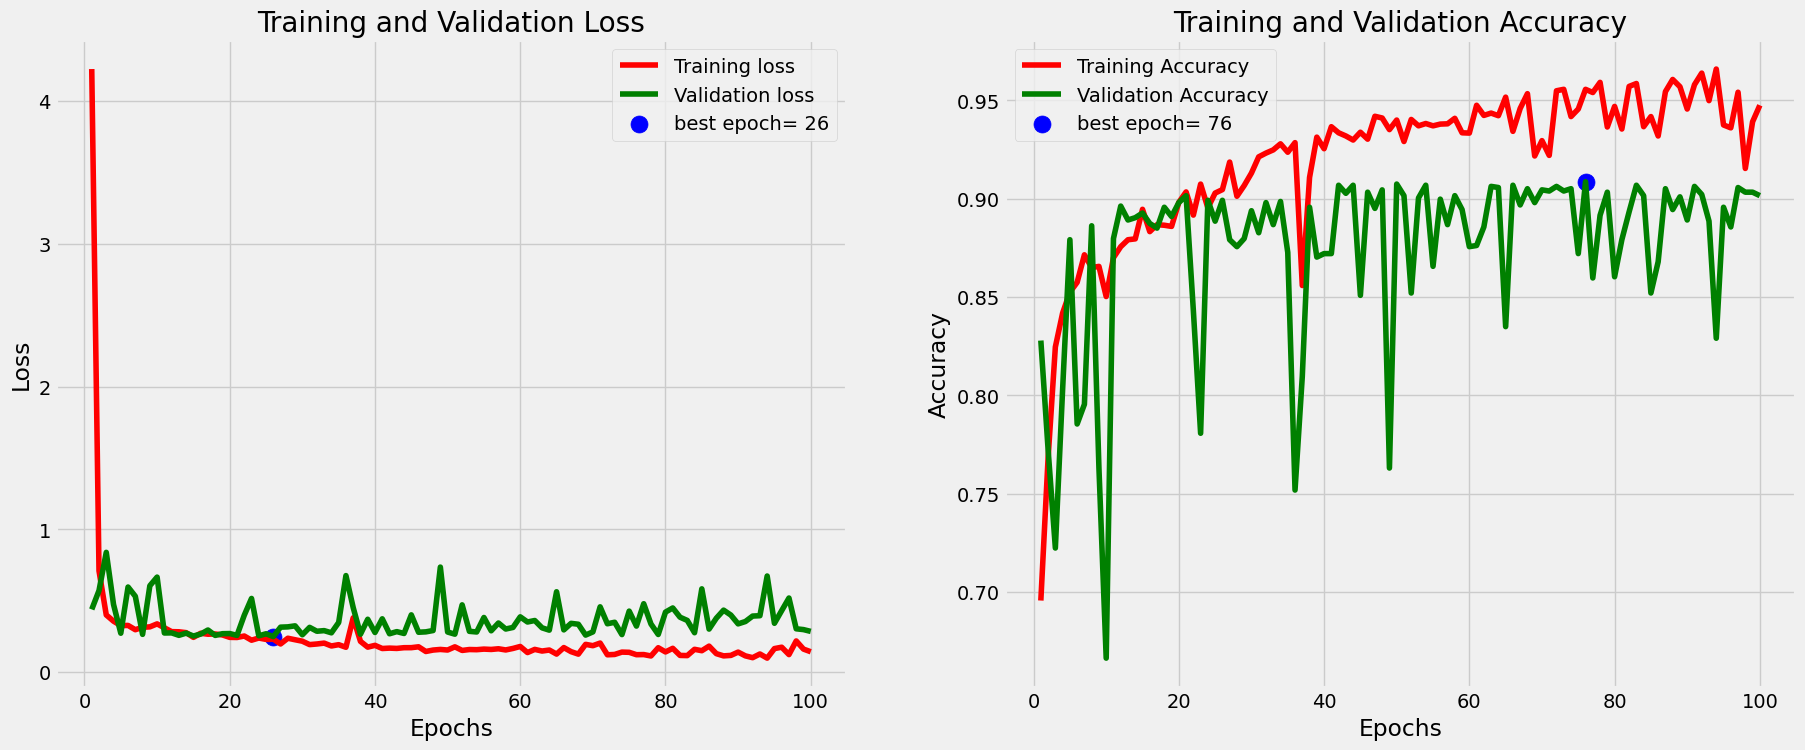

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(X_train, y_train) # Use base_model
test_score = model.evaluate(X_test, y_test) # Use base_model

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", test_score[0])
print("Validation Accuracy: ", test_score[1])
print('-' * 20)

266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9599 - loss: 0.1165
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8983 - loss: 0.2456
Train Loss:  0.1458636075258255
Train Accuracy:  0.9484912753105164
--------------------
Validation Loss:  0.2493789941072464
Validation Accuracy:  0.9014616012573242
--------------------


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


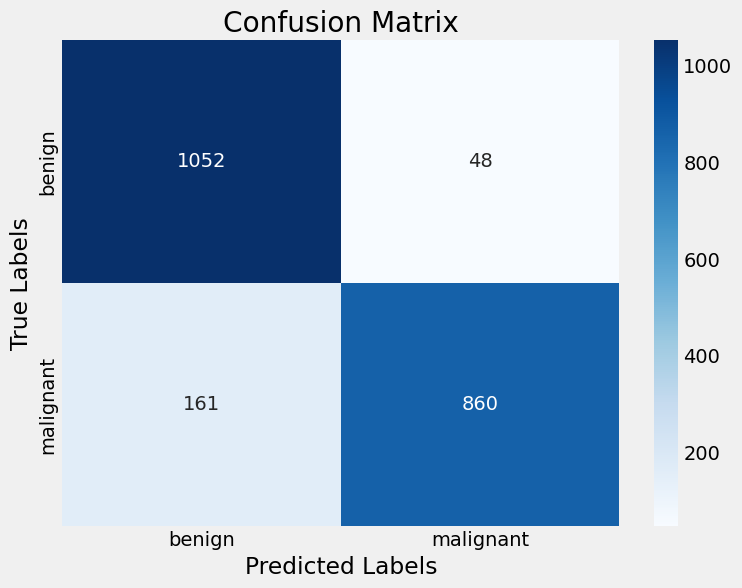

              precision    recall  f1-score   support

      benign       0.87      0.96      0.91      1100
   malignant       0.95      0.84      0.89      1021

    accuracy                           0.90      2121
   macro avg       0.91      0.90      0.90      2121
weighted avg       0.91      0.90      0.90      2121



In [ ]:
# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
